# GARMIN GPX FILE FOR TARGET HEART RATE & CYCLING VARIABLES
---
---

In [1]:
# Lesson 5.02 Webscraping
# https://towardsdatascience.com/data-science-for-cycling-how-to-read-gpx-strava-routes-with-python-e45714d5da23
# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
# https://geographiclib.sourceforge.io/html/python/code.html#geographiclib.geodesic.Geodesic.AZIMUTH
# https://www.python-graph-gallery.com/43-use-categorical-variable-to-color-scatterplot-seaborn

# Imports
---

In [2]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# https://towardsdatascience.com/data-science-for-cycling-how-to-read-gpx-strava-routes-with-python-e45714d5da23
import gpxpy
import gpxpy.gpx

# Lesson 5.02
from bs4 import BeautifulSoup
import lxml

# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
from geographiclib.geodesic import Geodesic

# for distance calculations
import haversine as hs

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

# Function: gpx_to_df()
---

In [3]:
def gpx_to_df(filepath):
    
    # Open .gpx file and parse xml
    with open(filepath, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        
    # check length of tracks
    print(f'Tracks: {len(gpx.tracks)}')
    # check number of data points
    print(f'No. of Track Points: {gpx.get_track_points_no()}')
    
    # extract timestamp, lat, lon, and elevation from gpx file
    route_info = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                route_info.append({
                    'timestamp': point.time,
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                })
    
    # create dataframe
    route_df = pd.DataFrame(route_info)
    
    #######################
    # HEART RATE AND CADENCE
    # add extension data with beautifulsoup
    xml = gpx.to_xml()
    soup = BeautifulSoup(xml, features = 'xml')
    
    # Use Beautiful Soup to find all heart rate and cadence
    hr_soup = soup.find_all('ns3:hr')
    cad_soup = soup.find_all('ns3:cad')
    
    # chop off early points from index - accounts for before cadence sensor calibration
    route_df = route_df[-len(cad_soup):]

    # for loop to extract heart rate and cadence values from each point
    hr_list = []
    cad_list = []
    for i in hr_soup:
        # https://stackoverflow.com/questions/69420686/bs4-element-resultset-elements-to-a-list
        hr_list.append(i.get_text(strip = True))

    for j in cad_soup:
        cad_list.append(j.get_text(strip = True))

    # add columns to dataset from extraction
    route_df['heart_rate'] = hr_list[-len(cad_soup):]
    route_df['cadence'] = cad_list
    
    #######################
    # BEARING
    # get_bearing function
    def get_bearing(lat1, lat2, long1, long2):
        brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
        return brng
    
    # assign bearing in df
    route_df['bearing'] = 0
    for i in range(1, len(a_885)):
        lat1 = route_df.latitude.iloc[i-1]
        lat2 = route_df.latitude.iloc[i]
        long1 = route_df.longitude.iloc[i-1]
        long2 = route_df.longitude.iloc[i]
        bearing = get_bearing(lat1, lat2, long1, long2)
        # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values
        route_df.bearing.iloc[[i]] = bearing
    
    ########################    
    # ELAPSED TIME - SECONDS
    route_df['timestamp'] = pd.to_datetime(route_df['timestamp'])
    route_df['time_diff_s'] = 0
    for i in range(1, len(route_df)-1):
        t1 = route_df.iloc[i]['timestamp']
        t2 = route_df.iloc[i-1]['timestamp']
        # https://www.geeksforgeeks.org/how-to-set-cell-value-in-pandas-dataframe/
        route_df.at[i, 'time_diff_s'] = (t1 - t2).seconds
    route_df['total_time_s'] = route_df['time_diff_s'].cumsum(skipna = True)
    
    #######################
    # ELEVATION CHANGE 
    route_df['ele_diff'] = 0
    for i in range(1, len(route_df)-1):
        e1 = route_df.iloc[i]['elevation']
        e2 = route_df.iloc[i-1]['elevation']
        route_df.at[i, 'ele_diff'] = (e1 - e2)
    route_df['total_ele_change'] = route_df['ele_diff'].cumsum(skipna = True)
    
    #######################
    # DISTANCE - KILOMETERS
    route_df['lat_lon'] = [(lat, lon) for lat, lon in zip(route_df['latitude'], route_df['longitude'])]
    route_df['dist_diff_km'] = 0
    for i in range(1, len(route_df)-1):
        loc1 = route_df.iloc[i]['lat_lon']
        loc2 = route_df.iloc[i-1]['lat_lon']
        route_df.at[i, 'dist_diff_km'] = hs.haversine(loc1, loc2) # kilometers
    route_df['total_dist_km'] = route_df['dist_diff_km'].cumsum(skipna = True)
   
    #######################
    route_df.reset_index(drop = True, inplace = True)
    
    return route_df

# Function: Build Out of gpx_to_df()
---

## Garmin GPX File

In [4]:
# Open .gpx file and parse xml
with open('../data/testing/activity_9305828885.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [5]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [6]:
# check length of tracks
print(f'Tracks: {len(gpx.tracks)}')
# check number of data points
print(f'No. of Track Points: {gpx.get_track_points_no()}')

Tracks: 1
No. of Track Points: 1333


In [7]:
# explore
moving_data = gpx.get_moving_data(raw=True)
moving_data

MovingData(moving_time=4591.0, stopped_time=601.0, moving_distance=27617.552711962377, stopped_distance=24.779016778381447, max_speed=49.9794491353225)

In [8]:
gpx.get_uphill_downhill()

UphillDownhill(uphill=140.3600003242493, downhill=139.56000108718894)

In [9]:
gpx.extensions

[]

### Pull Dataset from GPX

In [10]:
# check out .gpx file as xml
# gpx.to_xml()[:2000]

In [11]:
# extract timestamp, lat, lon, and elevation from gpx file
a_885_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            a_885_info.append({
                'timestamp': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
            })

In [12]:
a_885 = pd.DataFrame(a_885_info)

In [13]:
a_885.head()

,timestamp,latitude,longitude,elevation
0,2022-07-30 19:29:44+00:00,38.773742,-121.363474,35.200001
1,2022-07-30 19:29:45+00:00,38.773660,-121.364041,35.000000
2,2022-07-30 19:29:49+00:00,38.773795,-121.363652,35.000000
3,2022-07-30 19:29:51+00:00,38.773860,-121.363689,35.000000
4,2022-07-30 19:29:53+00:00,38.773917,-121.363619,35.000000


## BeautifulSoup for Extension Data - heartrate, cadence

In [14]:
xml = gpx.to_xml()
soup = BeautifulSoup(xml, features = 'xml')

In [15]:
time_soup = soup.find_all('time')
hr_soup = soup.find_all('ns3:hr')
cad_soup = soup.find_all('ns3:cad')

In [16]:
# type(time_soup)

In [17]:
# len(time_soup)

In [18]:
# type(hr_soup)

In [19]:
# len(hr_soup)

In [20]:
# len(soup.find_all('ns3:hr')[-len(cad_soup):])

In [21]:
# len(cad_soup)

In [22]:
# len(route_df)

In [23]:
# chop off early points from index - accounts for before cadence sensor calibration
route_df = route_df[-len(cad_soup):]

# for loop to extract heart rate and cadence values from each point
hr_list = []
cad_list = []
for i in hr_soup:
    hr_list.append(i.get_text(strip = True))
    
for j in cad_soup:
    cad_list.append(j.get_text(strip = True))

NameError: name 'route_df' is not defined

In [ ]:
# add columns to dataset from extraction
route_df['heart_rate'] = hr_list[-len(cad_soup):]
route_df['cadence'] = cad_list

In [ ]:
# route_df['cadence'].value_counts()

In [ ]:
a_885 = gpx_to_df('../data/testing/activity_9305828885.gpx')

In [ ]:
# a_885.tail(12)

### Beautiful Soup

In [24]:
xml = gpx.to_xml()
soup = BeautifulSoup(xml, features = 'xml')

# Use Beautiful Soup to find all heart rate and cadence
hr_soup = soup.find_all('ns3:hr')
cad_soup = soup.find_all('ns3:cad')

# chop off early points from index - accounts for before cadence sensor calibration
a_885 = a_885[-len(cad_soup):]

# for loop to extract heart rate and cadence values from each point
hr_list = []
cad_list = []
for i in hr_soup:
    # https://stackoverflow.com/questions/69420686/bs4-element-resultset-elements-to-a-list
    hr_list.append(i.get_text(strip = True))

for j in cad_soup:
    cad_list.append(j.get_text(strip = True))

# add columns to dataset from extraction
a_885['heart_rate'] = hr_list[-len(cad_soup):]
a_885['cadence'] = cad_list

## Create Bearing Column

In [25]:
def get_bearing(lat1, lat2, long1, long2):
    brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
    return brng

In [26]:
get_bearing(38.773795, 38.773860, -121.363652, -121.363689)

-24.017929532262528

In [27]:
a_885['bearing'] = 0
for i in range(1, len(a_885)):
    lat1 = a_885.latitude.iloc[i-1]
    lat2 = a_885.latitude.iloc[i]
    long1 = a_885.longitude.iloc[i-1]
    long2 = a_885.longitude.iloc[i]
    bearing = get_bearing(lat1, lat2, long1, long2)
    # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values
    a_885.bearing.iloc[[i]] = bearing

In [28]:
#a_885.head(10)

## Create Distance Column

In [29]:
a_885['lat_lon'] = [(lat, lon) for lat, lon in zip(a_885['latitude'], a_885['longitude'])]

In [30]:
a_885['dist_diff_km'] = 0
for i in range(1, len(a_885)-1):
    loc1 = a_885.iloc[i]['lat_lon']
    loc2 = a_885.iloc[i-1]['lat_lon']
    a_885.at[i, 'dist_diff_km'] = hs.haversine(loc1, loc2) # kilometers
a_885['total_dist_km'] = a_885['dist_diff_km'].cumsum(skipna = True)

In [31]:
a_885

,timestamp,latitude,longitude,elevation,heart_rate,cadence,bearing,lat_lon,dist_diff_km,total_dist_km
2,2022-07-30 19:29:49+00:00,38.773795,-121.363652,35.000000,92,0,0.000000,"(38.77379475161433, -121.36365221813321)",0.008786,0.008786
3,2022-07-30 19:29:51+00:00,38.773860,-121.363689,35.000000,93,0,-23.894707,"(38.7738602142781, -121.36368926614523)",0.015130,0.023915
4,2022-07-30 19:29:53+00:00,38.773917,-121.363619,35.000000,94,0,44.123442,"(38.773917043581605, -121.36361885815859)",0.021351,0.045267
5,2022-07-30 19:29:57+00:00,38.774025,-121.363512,35.000000,95,0,37.663356,"(38.77402491867542, -121.36351249180734)",0.015712,0.060979
6,2022-07-30 19:30:03+00:00,38.774181,-121.363370,34.799999,98,0,35.482394,"(38.77418149262667, -121.3633699156344)",0.019371,0.080350
...,...,...,...,...,...,...,...,...,...,...
1329,2022-07-30 20:56:14+00:00,38.773811,-121.363648,36.200001,131,0,-152.925202,"(38.77381084486842, -121.36364785954356)",0.002527,27.503481
1330,2022-07-30 20:56:15+00:00,38.773788,-121.363646,36.200001,128,0,176.846923,"(38.77378821372986, -121.36364626698196)",0.000000,27.503481
1331,2022-07-30 20:56:18+00:00,38.773766,-121.363642,36.000000,126,0,171.199836,"(38.77376575022936, -121.36364182457328)",0.000000,27.503481
1332,2022-07-30 20:56:19+00:00,38.773766,-121.363642,36.000000,126,0,180.000000,"(38.77376575022936, -121.36364182457328)",0.000000,27.503481


# Plot

<Figure size 1152x576 with 0 Axes>

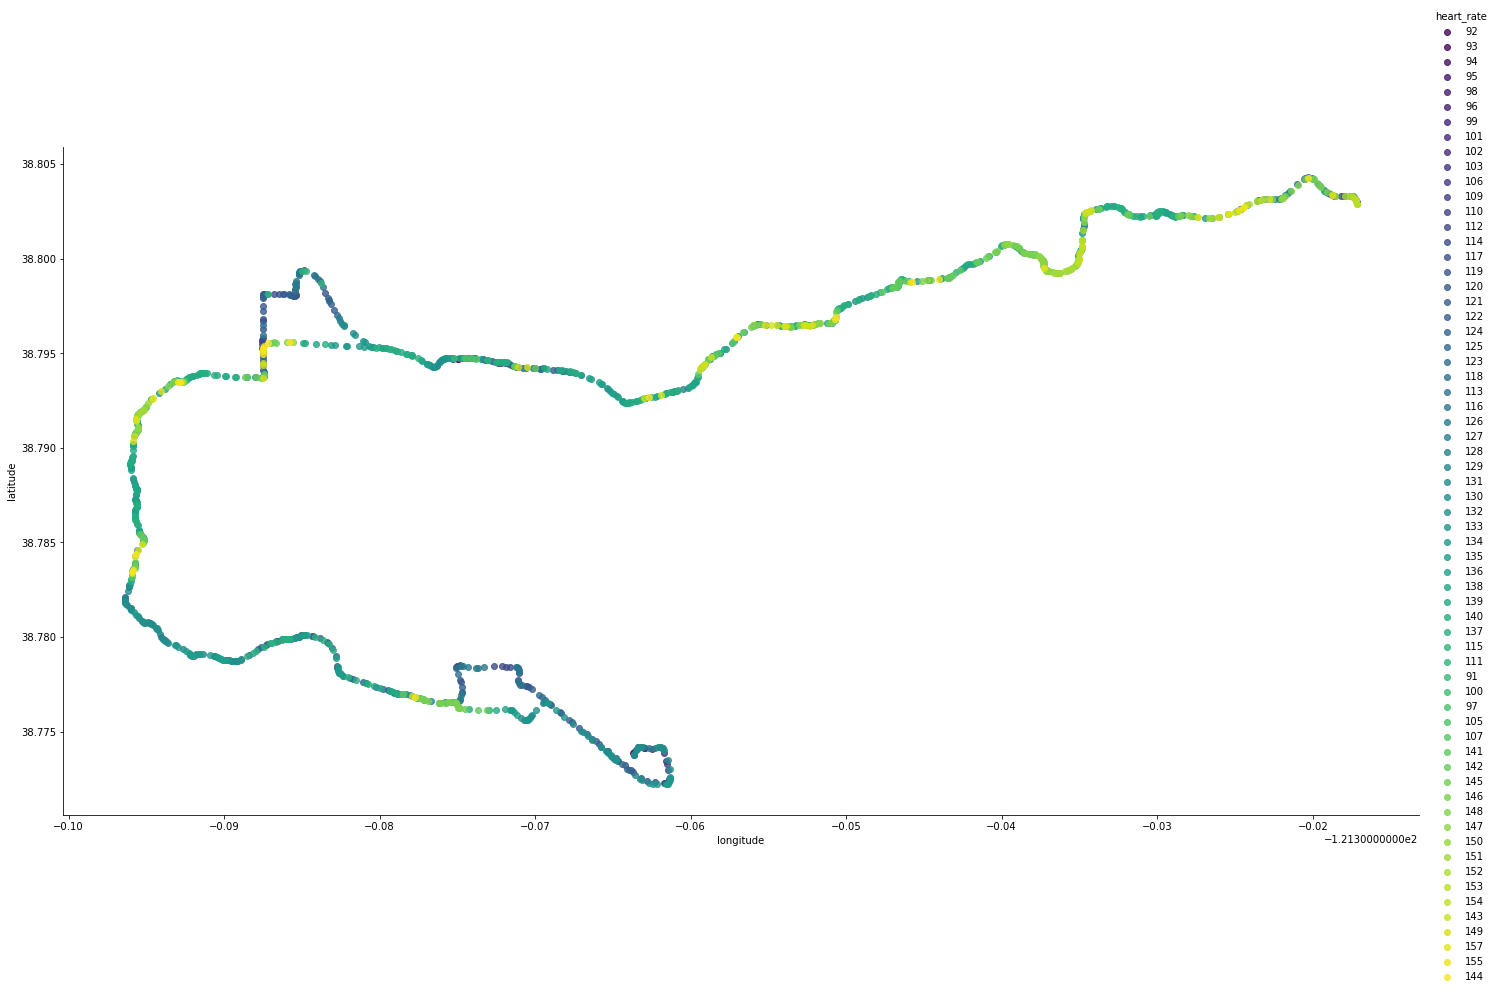

In [35]:
# Use the 'hue' argument to provide a factor variable
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=a_885, fit_reg=False, 
           hue='heart_rate', 
           palette = 'viridis', 
           height = 10, aspect = 2)
 
# Move the legend to an empty part of the plot
# plt.legend(loc='lower right')

plt.show();